## Logging device states and test results to a database
A number of tools are included in `labbench` to streamline acquisition of test data into a database. A couple of methods are

* Automatically monitoring attributes in `state` and logging changes
* Saving postprocessed data in the as a new column

The data management supports automatic relational databasing. Common non-scalar data types (`pandas.DataFrame`, `numpy.array`, long strings, files generated outside of the data tree, etc.) are automatically stored relationally --- placed in folders and referred to in the database. Other data can be forced to be relational by dynamically generating relational databases on the fly.

#### File conventions
All labbench data save functionality is implemented in tables with [pandas](pandas.pydata.org) DataFrame backends. Here are database storage formats that are supported:

| Format                            | File extension(s)              | Data management class | flag to [use record file format](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToRelationalTable.set_relational_file_format) | Comments |
|:----------------------------------|:-------------------------------|:-----------------------|:------------------------|:----
| [sqlite](sqlite.org)              | .db                            | [labbench.StatesToSQLite](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToSQLite) | 'sqlite' | Scales to larger databases than csv |
| csv                               | .csv,.csv.gz,.csv.bz2,.csv.zip | [labbench.StatesToCSV](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToCSV)          |'csv'| Easy to inspect |

Several formats are supported only as relational data (data stored in a file in the subdirectory instead of directly in the ). Certain types of data as values into the database manager automatically become relational data when you call the `append` method of the data manager:

| Format                            | File extension(s)              | python type conversion | [set_record file format](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToRelationalTable.set_relational_file_format) flag | Comments |
|:----------------------------------|:-------------------------------|:-----------------------|:------------------------|:----
| [feather](github.com/wesm/feather)| .f                             | iterables of numbers and strings; pd.DataFrame | 'feather' | Python 3.x only
| [json](http://www.json.org/)      | .json                          | iterables of numbers and strings; pd.DataFrame         | 'json' | |
| csv                               | .csv | iterables of numbers and strings; pd.DataFrame         |'csv'| |
| python [pickle](https://docs.python.org/3/library/pickle.html) | .pickle | any | 'pickle' | fallback if the chosen relational format fails |
| text files     | .txt | string or bytes longer than `text_relational_min` | N/A | set `text_relational_min` when you instantiate the database manager
| arbitrary files generated outside the file tree |     *             | strings containing filesystem path | N/A |

In the following example, we will use an sqlite master database, and csv record files. 

#### Example
Here is a emulated "dummy" instrument. It has a few state settings similar to a simple power sensor. The state descriptors (`initiate_continuous`, `output_trigger`, etc.) are defined as local types, which means they don't trigger communication with any actual devices. The `fetch_trace` method generates a "trace" drawn from a uniform distribution.

In [1]:
import sys
sys.path.insert(0,'..')
import labbench as lb
import numpy as np
import pandas as pd

class EmulatedInstrument(lb.EmulatedVISADevice):
    ''' This "instrument" makes mock data and instrument states to
        demonstrate we can show the process of setting
        up a measurement.
    '''
    class state (lb.EmulatedVISADevice.state):
        initiate_continuous = lb.Bool(command='INIT:CONT')
        output_trigger      = lb.Bool(command='OUTP:TRIG')
        sweep_aperture      = lb.Float(min=20e-6, max=200e-3,help='s')
        frequency           = lb.Float(min=10e6, max=18e9,step=1e-3,help='Hz')

    def trigger(self):
        ''' This would tell the instrument to start a measurement
        '''
        pass
    
    def fetch_trace(self, N=1001):
        ''' Generate N points of junk data as a pandas series.
        '''
        values = np.random.normal(size=N)
        index = np.linspace(0,self.state.sweep_aperture,N)
        series = pd.Series(values,index=index,name='voltage')
        series.index.name = 'time'
        return series

Now make a loop to execute 100 test runs with two emulated instruments, and log the results with a relational SQLite database. I do a little setup to start:

1. Define a couple of functions `inst1_trace` and `inst2_trace` that collect my data
2. Instantiate 2 instruments, `inst1` and `inst2`
3. Instantiate the logger with `lb.StatesToSQLite('test.db', 'state')`.
   The arguments specify the name of the sqlite database file and the name of the table where the following will be stored: 1) the instrument state info will be stored, 2) locations of data files, and 3) any extra comments we add with `db.write()`.

Remember that use of the `with` statement automatically connects to the instruments, and then ensures that the instruments are properly closed when we leave the `with` block (even if there is an exception).

In [18]:
def inst1_trace ():
    ''' Return a 1001-point trace
    '''
    inst1.trigger()
    return inst1.fetch_trace(51)

def inst2_trace ():
    ''' This one returns only one point
    '''
    inst2.trigger()
    return inst2.fetch_trace(1).values[0]
    
# Root directory of the database
db_path = r'data'

# Seed the data dictionary with some global data
data = {'dut': 'DUT 15'}

Nfreqs = 101

with EmulatedInstrument()        as inst1,\
     EmulatedInstrument()        as inst2,\
     lb.StatesToSQLite(db_path, nonscalar_output='csv')  as db:
        # Catch any changes in inst1.state and inst2.state
        db.observe_states([inst1,inst2])  
        
        # Update inst1.state.sweep_aperture on each db.append
        db.observe_states(inst1, always='sweep_aperture')
        
        # Store trace data in csv format
        db.set_relational_file_format('csv')
        
        # Perform a frequency sweep. The frequency will be logged to the
        # database, because we configured it to observe all state changes.
        inst2.state.frequency = 5.8e9
        for inst1.state.frequency in np.linspace(5.8e9, 5.9e9, Nfreqs):                    
            # Collect "test data" by concurrently calling
            # inst1_trace and inst2_trace
            data.update(lb.concurrently(inst1_trace, inst2_trace))

            # Append the new data as a row to the database.
            # Each key is a column in the database (which will be added
            # dynamically to the database if needed). More keys and values
            # are also added corresponding to attributes inst1.state and inst2.state
            db.append(comments='trying for 1.21 GW to time travel',
                      **data)

..\labbench\data.py:841: UserWarning: set_nonscalar_file_type is deprecated; set when creating
                         the database object instead with the nonscalar_output flag
  the database object instead with the nonscalar_output flag''')


#### Reading and exploring the data
The master database is now populated with the test results and subdirectories are populated with trace data. `labbench` provides the function `read` as a shortcut to load the sqlite database into a pandas dataframe. Each state is a column in the database. The logger creates columns named as a combination of the device name ('inst1') and name of the corresponding device state.

In [19]:
%pylab inline
master = lb.read(f'{db_path}/master.db')
master.head()

Populating the interactive namespace from numpy and matplotlib


,comments,dut,host_log,host_time,inst1_frequency,inst1_sweep_aperture,inst1_trace,inst2_frequency,inst2_sweep_aperture,inst2_trace
id,,,,,,,,,,
0,trying for 1.21 GW to time travel,DUT 15,0 2019-06-25 152317.734882\host_log.txt,2019-06-25 15:23:17.734882,5.800000e+09,0.192369,0 2019-06-25 152317.734882\inst1_trace.csv,5.800000e+09,0.167496,0.400305
1,trying for 1.21 GW to time travel,DUT 15,1 2019-06-25 152317.736860\host_log.txt,2019-06-25 15:23:17.736860,5.801000e+09,0.109682,1 2019-06-25 152317.736860\inst1_trace.csv,5.800000e+09,0.171570,-2.691761
2,trying for 1.21 GW to time travel,DUT 15,2 2019-06-25 152317.737861\host_log.txt,2019-06-25 15:23:17.737861,5.802000e+09,0.178361,2 2019-06-25 152317.737861\inst1_trace.csv,5.800000e+09,0.000206,-0.870499
3,trying for 1.21 GW to time travel,DUT 15,3 2019-06-25 152317.738881\host_log.txt,2019-06-25 15:23:17.738881,5.803000e+09,0.139515,3 2019-06-25 152317.738881\inst1_trace.csv,5.800000e+09,0.182937,0.733112
4,trying for 1.21 GW to time travel,DUT 15,4 2019-06-25 152317.740859\host_log.txt,2019-06-25 15:23:17.740859,5.804000e+09,0.177053,4 2019-06-25 152317.740859\inst1_trace.csv,5.800000e+09,0.184841,0.623774


This is a pandas DataFrame object. There is extensive information about how to use dataframes [on the pandas website](http://pandas.pydata.org/pandas-docs/stable/). Suppose we want to bring in the data from the traces, which are in a collection of waveform files specified under the `inst1_trace` column. The function `labbench.expand` serves to flatten the database with respect to data files that were generated on each row.

In [13]:
waveforms = lb.read_relational(f'{db_path}/master.db', 'inst1_trace', ['dut', 'inst1_frequency'])
waveforms

,dut,inst1_frequency,inst1_trace,inst1_trace_id,inst1_trace_time,inst1_trace_voltage
0,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,0,0.000000,-0.068554
1,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,1,0.002176,-0.869817
2,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,2,0.004351,-0.257835
3,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,3,0.006527,1.032947
4,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,4,0.008702,-0.815933
5,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,5,0.010878,0.072944
6,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,6,0.013053,-1.308240
7,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,7,0.015229,-0.963079
8,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,8,0.017404,1.312735
9,DUT 15,5.800000e+09,0 2019-06-25 152317.734882\inst1_trace.csv,9,0.019580,-2.294348


now we can manipulate the results to look for meaningful information in the data.

Text(0, 0.5, 'Voltage (arb units)')

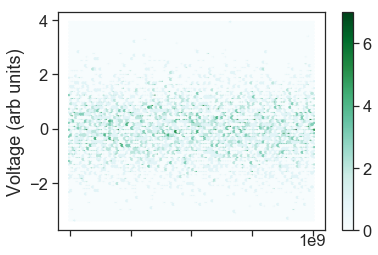

In [14]:
import seaborn as sns; sns.set(context='notebook', style='ticks', font_scale=1.5) # Theme stuff

waveforms.plot(x='inst1_frequency',y='inst1_trace_voltage',kind='hexbin')
xlabel('Frequency (Hz)')
ylabel('Voltage (arb units)')